## _PandaML_

- Perform detailed Exploratory Data Analysis on STT Data.

In [1]:
import os
import glob
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import trackml.dataset
import tensorflow as tf
import seaborn as sns

## Dataset

In [3]:
# path to the dataset
path = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [4]:
# select an event
event_id = 2

In [5]:
# load event using trackml.dataset (update: pandaroot will now generate tubes.csv as cells.csv)
event_prefix = str('event{!s}'.format(format(event_id, '010d')))
prefix = path + str('event{!s}'.format(format(event_id, '010d')))
hits, tubes, particles, truth = trackml.dataset.load_event(prefix)

mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(event_prefix, mem_bytes / 2**20))

event0000000002 memory usage 0.01 MB


In [6]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-6.12280,-15.655000,35.0,9,0,48
1,2,-6.99749,-16.160000,35.0,9,1,154
2,3,-6.99749,-17.170000,35.0,9,2,267
3,4,-7.87217,-17.674999,35.0,9,3,385
4,5,-7.87217,-18.684999,35.0,9,4,510


In [7]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.062153,15273000.0,15.27300,9,0,48,0,2
1,2,0.485507,2901860.0,2.90186,9,1,154,0,2
2,3,0.084492,12518600.0,12.51860,9,2,267,0,2
3,4,0.366787,6127680.0,6.12768,9,3,385,0,2
4,5,0.218553,14618900.0,14.61890,9,4,510,0,2


In [8]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,0.000000,-0.000000,1.642000,0,1,88888,0
1,2,0.0,0.0,0.0,-0.080749,-0.009465,0.498454,0,1,2212,0
2,3,0.0,0.0,0.0,-0.097025,0.039273,0.212149,0,1,-211,0
3,4,0.0,0.0,0.0,0.201635,0.091849,0.697453,0,1,-2212,0
4,5,0.0,0.0,0.0,-0.023861,-0.121658,0.233945,0,1,211,0


In [9]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-6.13515,-15.647600,31.807100,-0.062007,-0.103075,0.224405,0.0,5
1,2,-6.60323,-16.410000,33.474800,-0.064706,-0.101951,0.224082,0.0,5
2,3,-7.06991,-17.121700,35.050701,-0.066850,-0.100841,0.223882,0.0,5
3,4,-7.58211,-17.876499,36.736900,-0.069040,-0.099612,0.223697,0.0,5
4,5,-8.05966,-18.549700,38.261200,-0.070896,-0.098117,0.223732,0.0,5


## Hits

The hits file contains the following values for each hit/entry:

* __hit_id__: numerical identifier of the hit inside the event.
* __x, y, z__: measured x, y, z position (in millimeter) of the hit in global coordinates.
* __volume_id__: numerical identifier of the detector group.
* __layer_id__: numerical identifier of the detector layer inside the group.
* __module_id__: numerical identifier of the detector module inside the layer.


Here we have the $x, y, z$ global coordinates (in cm) of where the particles hit the detector surface. The volume/layer/module id could in principle be deduced from x, y, z. They are given here to simplify detector-specific data handling.

In [10]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-6.12280,-15.655000,35.0,9,0,48
1,2,-6.99749,-16.160000,35.0,9,1,154
2,3,-6.99749,-17.170000,35.0,9,2,267
3,4,-7.87217,-17.674999,35.0,9,3,385
4,5,-7.87217,-18.684999,35.0,9,4,510


Here is the distribution of $x, y, z$ location of hits in an event.

### Vertical Intersection ($x, y$) in Detection Layers
As shown in the figure below, the hits are semi evenly distributed on the detector surface $x, y$.  The white circle in the center of the plot is where the beam pipe lies.  Thanks [agerom] for [the clarification][clar].

The colors represent different detector volumes.  Thanks to [Joshua Bonatt's notebook][josh].

[josh]: https://www.kaggle.com/jbonatt/trackml-eda-etc
[clar]: https://www.kaggle.com/wesamelshamy/trackml-problem-explanation-and-data-exploration/comments#323803
[agerom]: https://www.kaggle.com/artemiosgeromitsos

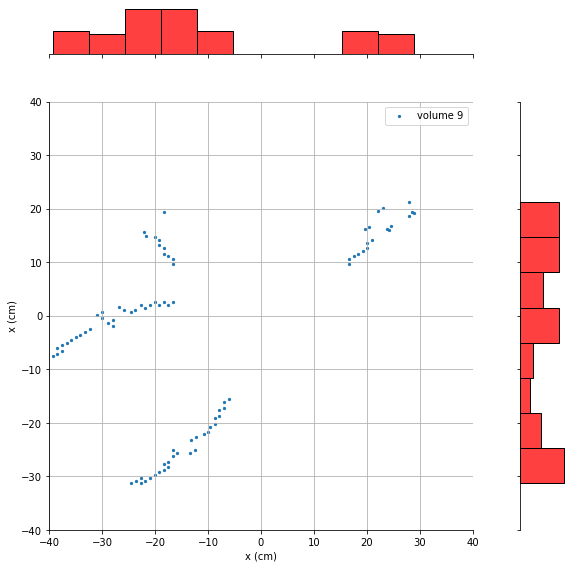

In [11]:
# Plotting with Seaborn & Matplotlib:
g = sns.jointplot(data=hits, x='x', y='y', space=1, height=8, color="r")
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=5, label='volume {}'.format(volume))

plt.xlabel('x (cm)')
plt.ylabel('x (cm)')
plt.xlim((-40,40))
plt.ylim((-40,40))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=10, loc='best')
plt.show()

### Horizonal Intersection ($y, z$) in Detection Layers
You can think of the chart below as a horizontal intersection in the detection surface, where every dot is a hit.  Notice the relationship between the different activity levels in this chart and the one above for $x, y$.

Again, the colors represent different volumes in the detector surface.

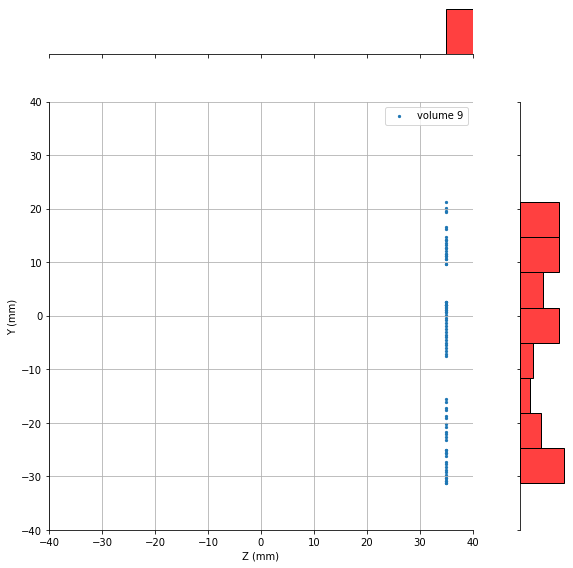

In [12]:
g = sns.jointplot(data=hits, x='z', y='y', space=1, height=8, color="r")
g.ax_joint.cla()
plt.sca(g.ax_joint)

volumes = hits.volume_id.unique()
for volume in volumes:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.z, v.y, s=5, label='volume {}'.format(volume))
    
plt.xlabel('Z (mm)')
plt.ylabel('Y (mm)')
plt.xlim((-40,40))
plt.ylim((-40,40))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.legend(fontsize=10, loc='best')
plt.show()

### 3D Intersection ($x, y, z$) in Detection Layers

And here is how the hits in this event look like in 3D.  Again, a sample from one event.  This combines the previous two charts in 3D.

Notice how the particles penetrate the detector surface along $z$ coordinate.

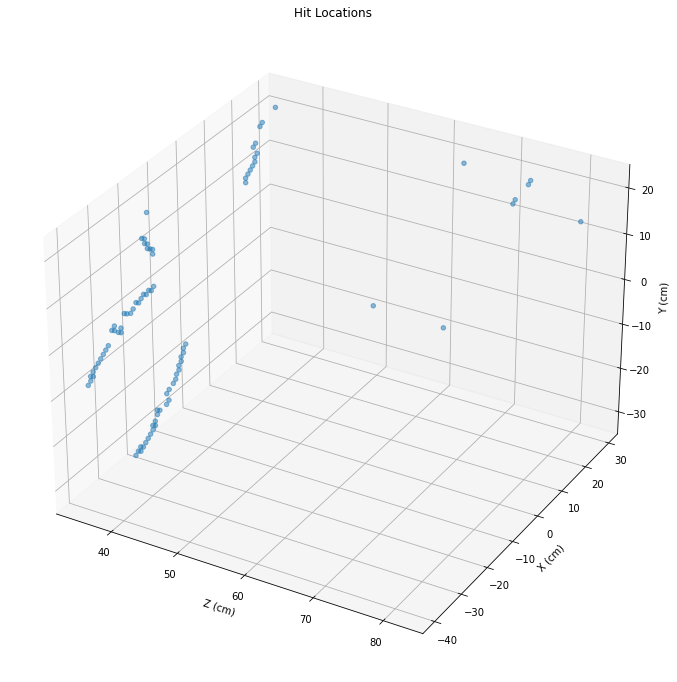

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, label='volume {}'.format(volume), alpha=0.5)

ax.set_title('Hit Locations')
ax.set_xlabel('Z (cm)')
ax.set_ylabel('X (cm)')
ax.set_zlabel('Y (cm)')
plt.show()